In [74]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.decomposition import PCA

import lightgbm as lgbm
import xgboost as xgb

from imblearn.over_sampling import SMOTE

from IPython.display import display

sns.set()
sns.set(rc={'figure.figsize':(18,12)})

In [3]:
df = pd.read_csv('data/train_final.csv', index_col='Id')
df_ult = pd.read_csv('data/test_final.csv', index_col='Id')

X = df.drop('Y', axis='columns').values
y = df['Y'].values

X_ult = df_ult.values

# scale_pos_weight = len(y[y == 0])/len(y[y == 1])

In [24]:
def transform(df, y=True):
    df_copy = df.copy()
    df_copy['f8-f19'] = df['f8'] - df['f19']
    df_copy['f8-f13'] = df['f8'] - df['f13']
    df_copy['f17-f4'] = df['f17'] - df['f4']
    df_copy['f4-f7'] = df['f4'] - df['f7']
    df_copy['f13-f19'] = df['f13'] - df['f19']
    df_copy['f8wf13wf19'] = PCA(n_components=1).fit_transform(df[['f8', 'f13', 'f19']])
    return df_copy.drop('Y', axis='columns') if y else df_copy

In [98]:
model = lgbm.LGBMRegressor(**{
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric': 'auc',
#     'max_depth': 11,
    'n_estimators': 10000,
#     'learning_rate': 0.075,
    'n_jobs': -1
})

model.fit(X, y);

In [99]:
model

LGBMRegressor(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric='auc', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
              objective='binary', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

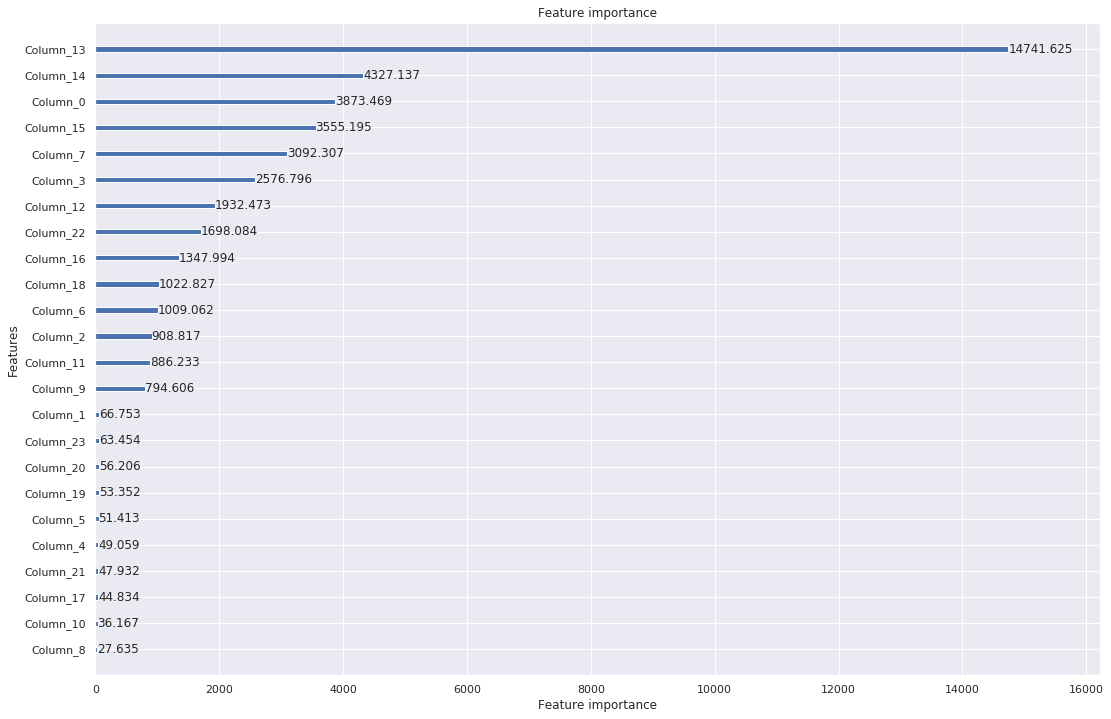

In [100]:
lgbm.plot_importance(model, importance_type='gain');

In [143]:
rfe_feats = [0, 3, 6, 7, 12, 13, 14, 15, 16, 18]
best_feats = [13, 0, 14, 15, 7, 3, 12, 18, 16]
sharang_feats = [13, 0, 14, 15, 7, 3, 12, 18, 22]
better_feats = [13, 0, 14, 15, 7, 3, 12, 18, 16] + [6, 22]
good_feats = better_feats + [22]

In [60]:
best_feats2 = [13, 0, 14, 15, 26, 3, 22, 12, 24, 29]
better_feats2 = best_feats2 + [7]
good_feats2 = better_feats2 + [25]
okay_feats2 = good_feats2 + [27]

In [150]:
fix_param = {
    'boosting_type':                 'goss', 
    'metric':                        'auc', 
    'objective':                     'binary', 
#     'scale_pos_weight':              scale_pos_weight, 
    'n_jobs':                        -1 
}

var_param = { 
    'max_depth':                     [14], 
    'n_estimators':                  [420, 400, 380], 
    'learning_rate':                 [0.08], 
    'min_child_weight':              [1], 
    'min_split_gain':                [1e-5], 
    'colsample_bytree':              [1e-3], 
    'reg_alpha':                     [0], 
    'reg_lambda':                    [1], 
}

scorer = make_scorer(lambda y_true, y_pred: roc_auc_score(y_true, y_pred), greater_is_better=True)

grid = GridSearchCV(lgbm.LGBMRegressor(**fix_param), 
                          var_param, 
                          cv=StratifiedKFold(5), 
                          scoring=scorer, 
                          n_jobs=-1)

matrix = X
#     matrix = transform(df).values
grid.fit(matrix[:, sharang_feats], y)

print(f'Best parameters {grid.best_params_}.')
print(f'Best auc score is {grid.best_score_}.')

Best parameters {'colsample_bytree': 0.001, 'learning_rate': 0.08, 'max_depth': 14, 'min_child_weight': 1, 'min_split_gain': 1e-05, 'n_estimators': 420, 'reg_alpha': 0, 'reg_lambda': 1}.
Best auc score is 0.896874664425818.
